Prototype stopped: Performance too bad. Try other preprocessing approach in next iteration.

# Sentiment Analysis Prototyping

Prototype code for ML-based sentiment analysis. Classification case neg/non-negative only.

In [1]:
import os, sys, re, string, pickle, random
sys.path.append("..")
from config import credentials
import dropbox

import numpy as np
import pandas as pd

import nltk
nltk.data.path.append("../data/external/nltk_data")
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.cistem import Cistem

import emoji

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, LeaveOneOut
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, PrecisionRecallCurve, ROCAUC

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random_state = 23
random.seed(random_state)

## Loading

In [3]:
team_dbx = dropbox.DropboxTeam(credentials.dropbox_team_access_token)
team_root = team_dbx.with_path_root(dropbox.common.PathRoot.namespace_id(
    credentials.dropbox_team_namespace_id))
user_dbx = team_root.as_user(credentials.dropbox_team_member_id)

data_path = "/Data/CSVData"
fpath = os.path.join(data_path, "TestData", "forSentAnalysis.csv")

_, res = user_dbx.files_download(fpath)
labeled_data = pd.read_csv(res.raw)
labeled_data.shape

(1342, 7)

Rating schema: {0: "positive", 10: "neutral", 20: "negative", 30: "offensive", -2: "notAssessable"}

## Preprocessing

Dataset cleansing

In [4]:
# Remove unnecessary cols and rename them uniformly
labeled_data.drop(["id", "Level", "Topic", "sentiment"], axis=1, inplace=True)
labeled_data.columns = ["source", "text", "rating"]

# Remove not assessable
labeled_data = labeled_data[labeled_data.rating != -2]

# Remove empty texts
labeled_data.text.replace("", np.nan, inplace=True)
labeled_data.dropna(subset=["text"], inplace=True)
labeled_data = labeled_data[~labeled_data.text.str.isspace()]

# Remove duplicated texts
labeled_data.drop_duplicates(subset=["text"], keep="first", inplace=True)

# Remap rating labels
new_rating_schema = {0: 1, 10: 1, 20:-1, 30:-1}
labeled_data.rating = labeled_data.rating.map(new_rating_schema)

labeled_data.shape

(1053, 3)

In [5]:
# from IPython.core.display import HTML
# HTML(labeled_data[["text", "rating"]].tail(100).to_html())

New rating schema: {1: "non-negative", -1: "negative"}

In [6]:
labeled_data.rating.value_counts()

 1    546
-1    507
Name: rating, dtype: int64

Text cleansing

In [7]:
stopwords_list = stopwords.words("german")
stemmer = Cistem()

def clean_text(text):
    """ Util: Cleans text string.
    > Lowercase string
    > Punctuation removal
    > Replace numbers with "NUM" placeholder
    > Removes urls
    > Split emojis away from words and each other
    > Stopwords removal
    > Stemming
    """
    lowercased = text.lower()
    split_emoji = emoji.get_emoji_regexp().split(lowercased) # splits emoji away
    punctuations = string.punctuation + "„" + "”" + "–" + "‘" + "’" + "“" + "…" + "‼"
    punct_removed = " ".join(split_emoji).translate(str.maketrans("", "", punctuations))
    num_replaced = re.sub(r"\b\d+\b", "NUM", punct_removed)
    urls_removed = re.sub(r"http\S+", "", num_replaced)
    tokenized = word_tokenize(urls_removed) 
    cleaned_tokens = [word for word in tokenized if word not in stopwords_list]
    stemmed = [stemmer.stem(word) for word in cleaned_tokens]
    cleaned_txt = " ".join(stemmed)
    
    return cleaned_txt


# def get_emoji_free(text):
#     return emoji.get_emoji_regexp().sub(r"", text)

# def clean_text(text):
#     """ Util: Cleans text string.
#     > Lowercase string
#     > Replace game scores with "GAME_SCORE" placeholder
#     > Punctuation removal
#     > Replace numbers with "NUM" placeholder
#     > Split emojis away from words and each other
#     > Stopwords removal
#     > Stemming
#     > Removes single characters
#     """
#     lowercased = text.lower()
#     emoji_free = get_emoji_free(lowercased)
#     punctuations = string.punctuation + "„" + "”" + "–" + "‘" + "’" + "“" + "…" + "‼"
#     punct_removed = emoji_free.translate(str.maketrans("", "",
#                                                            punctuations))
#     num_removed = re.sub(r"\b\d+\b", "", punct_removed)
#     urls_removed = re.sub(r"http\S+", "", num_removed)
#     tokenized = word_tokenize(urls_removed) 
#     cleaned_tokens = [word for word in tokenized if word not in stopwords_list]
#     stemmed = [stemmer.stem(word) for word in cleaned_tokens]
#     cleaned_txt = " ".join([word for word in stemmed if len(word) > 1])
    
#     return cleaned_txt


# Apply text cleansing and drop rows with empty cleaned_txt vals
labeled_data["cleaned_txt"] = labeled_data.text.apply(clean_text)
labeled_data.drop(labeled_data[labeled_data.cleaned_txt == ""].index, inplace=True)

In [8]:
#labeled_data[["text", "cleaned_txt", "rating"]].to_csv(os.path.join(data_path, "TestData", "labeled_sentiment.csv"), index=False)

## Exploration

NaN Stats

In [9]:
labeled_data.isna().sum()

source         0
text           0
rating         0
cleaned_txt    0
dtype: int64

Duplicated texts (after cleaning)

In [10]:
labeled_data.text.duplicated().value_counts()

False    1050
Name: text, dtype: int64

Distribution of sources

In [11]:
print("Sources count:", len(labeled_data.source.value_counts()))
print("Avg count of doc per source:", np.mean(labeled_data.source.value_counts().tolist()))
print("Top 5 sources:")
labeled_data.source.value_counts()[:5]

Sources count: 66
Avg count of doc per source: 15.909090909090908
Top 5 sources:


DIE_KRONE                 110
JOY_PAMELA_RENDIWAGNER    100
DER_STANDARD               71
FLORIAN_KLENK              70
NORBERT_HOFER              60
Name: source, dtype: int64

Distribution of ratings

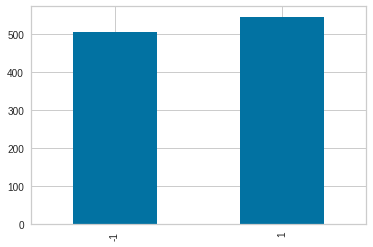

In [12]:
labeled_data.rating.value_counts(sort=False).plot(kind="bar")

-> we have more or less balanced (but generally too less) data.

## Sentiment Assignment

ML-based approach.

### Train/Test-Split

No need for Dev-Set, as we use cross-validation for model tuning.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.cleaned_txt, labeled_data.rating,
                                                    test_size=0.2, stratify=labeled_data.rating, 
                                                    random_state=random_state)

print("X shapes (train/test):", X_train.shape, "/", X_test.shape)
print("y shapes (train/test):", y_train.shape, "/", y_test.shape)

X shapes (train/test): (840,) / (210,)
y shapes (train/test): (840,) / (210,)


### Vectorizer

In [14]:
count_vect = CountVectorizer(lowercase=False, # already lowercased
                             tokenizer=word_tokenize,
                             #ngram_range=(1,2),
                             max_features=4000) # tune max_features for generalization eventually, 3gram 25k, 2gram 10k

tfidf = TfidfVectorizer(lowercase=False, # already lowercased
                        tokenizer=word_tokenize,
                        #ngram_range=(1,2),
                        max_features=4000) # tune max_features for generalization eventually, 3gram 25k, 2gram 10k

### Models

In [15]:
logreg = LogisticRegression(solver="liblinear", max_iter=4000, random_state=random_state, n_jobs=1)
nb = MultinomialNB()
rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)

models = [logreg, nb]

Parameters

In [16]:
params = {}
params["LogisticRegression"] = {"penalty": ["l2"],
                                "dual": [True],
                                "C": [0.01, 0.1, 1., 10., 50., 100., 200.],
                                "class_weight": [None, "balanced"]}
params["MultinomialNB"] = {"alpha": [1.0e-10, 1.],
                           "fit_prior": [True, False]}
# params["RandomForestClassifier"] = {"n_estimators": [2, 32, 64, 128, 256],
#                                     "criterion": ["gini", "entropy"],
#                                     "min_samples_leaf": [1, 2],
#                                     "max_features": ["auto"],
#                                     "class_weight": [None, "balanced"]}

### Pipeline

In [17]:
classifiers = {}
scoring = "f1"

# def get_post_length(txt):
#     """ Util: Length of text """
#     return np.array([len(t) for t in txt]).reshape(-1, 1)

for model in models:
    classifiers[type(model).__name__ + "_pipe"] = Pipeline([
        ("count_vect", count_vect),
        #("tfidf", tfidf),
        ("clf", GridSearchCV(model, param_grid=params[type(model).__name__],
                             scoring=scoring, cv=8, refit=True, n_jobs=-1))
    ])
#     classifiers[type(model).__name__ + "_pipe"] = Pipeline([
#         ("features", FeatureUnion([
#             ("text", Pipeline([
#                 ("count_vect", count_vect),
#                 #("tfidf", tfidf)
#             ])),
#             ("text_length", Pipeline([
#                 ("txt_len", FunctionTransformer(get_post_length, validate=False)),
#             ]))
#         ])),
#         ("clf", GridSearchCV(model, param_grid=params[type(model).__name__],
#                              scoring=scoring, cv=8, refit=True, n_jobs=-1))
#     ])

Train

In [18]:
for _, clf_pipeline in classifiers.items():
    clf_pipeline.fit(X_train, y_train)

Score

In [19]:
best_score = 0
best_model_pipe = None # = best generalization

for name, clf_pipeline in classifiers.items():
    y_pred = clf_pipeline.predict(X_test)
    scores = cross_validate(clf_pipeline, X_test, y_test, scoring=scoring, cv=8, n_jobs=1)
    mean_score = scores["test_score"].mean()
    mean_fit_time = scores["fit_time"].mean()
    
    print(name)
    print("Test score (mean):", mean_score)
    print("Test fit time (mean):", mean_fit_time)
    print("Train score:", clf_pipeline.named_steps["clf"].best_score_)
    print("Params:", clf_pipeline.named_steps["clf"].best_params_, "\n")
    
    if mean_score > best_score:
        best_model_pipe = clf_pipeline
        best_score = mean_score

LogisticRegression_pipe
Test score (mean): 0.598058579492403
Test fit time (mean): 0.3606669306755066
Train score: 0.6466807409510016
Params: {'C': 0.01, 'class_weight': None, 'dual': True, 'penalty': 'l2'} 

MultinomialNB_pipe
Test score (mean): 0.5390264539107457
Test fit time (mean): 0.22613942623138428
Train score: 0.6268814933074637
Params: {'alpha': 1e-10, 'fit_prior': False} 



In [20]:
#len(best_model_pipe.named_steps["count_vect"].get_feature_names())
#best_model_pipe.named_steps["count_vect"].vocabulary_

## Evaluation

In [21]:
print("Best pipeline CLF:", best_model_pipe.named_steps["clf"].best_estimator_)

Best pipeline CLF: LogisticRegression(C=0.01, class_weight=None, dual=True, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='warn', n_jobs=1, penalty='l2', random_state=23,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [22]:
class_encoding = {1: "non-negative", -1: "negative"}

#### Confusion Matrix

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


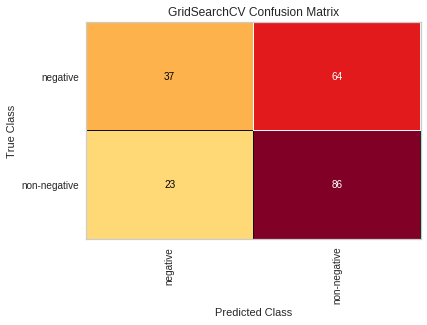

In [23]:
cm = ConfusionMatrix(best_model_pipe, is_fitted=True, encoder=class_encoding)
cm.score(X_test, y_test)
cm.poof()

#### Classification Report

              precision    recall  f1-score   support

          -1       0.62      0.37      0.46       101
           1       0.57      0.79      0.66       109

    accuracy                           0.59       210
   macro avg       0.59      0.58      0.56       210
weighted avg       0.59      0.59      0.57       210



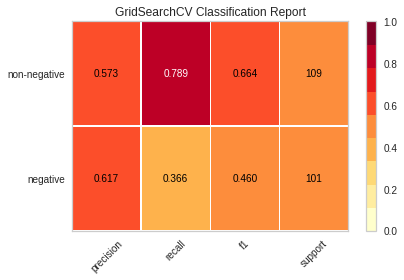

In [24]:
print(classification_report(y_test, best_model_pipe.predict(X_test)))

# Visualizer
report = ClassificationReport(best_model_pipe, is_fitted=True, encoder=class_encoding, support=True)
report.score(X_test, y_test)
report.poof()

#### Precision-Recall Curve

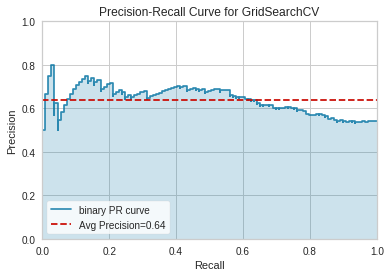

In [25]:
pr_curve = PrecisionRecallCurve(best_model_pipe)
pr_curve.fit(X_train, y_train)
pr_curve.score(X_test, y_test)
pr_curve.poof()

#### ROCAUC

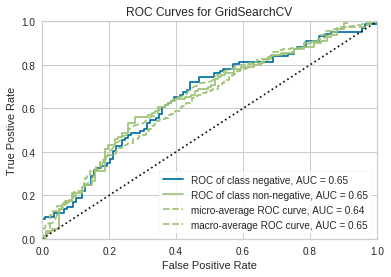

In [26]:
rocauc = ROCAUC(best_model_pipe, is_fitted=True, encoder=class_encoding)
rocauc.score(X_test, y_test)
rocauc.poof()

# Conclusion

None of tested combinations leads to an acceptable performance (or even a performance, which has potential to be enhanced with more distinguished modeling approaches). Therefore this prototype is stopped.
For further iteration:
* Test another preprocessing approach, as the hardcoded one, used in this NB might be bug-y.
* Test DL-approaches with embeddings.
* Question consistency of rated labels (sanity check by manual inspection).